In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
import os
import textwrap
from IPython.display import display, HTML
import time
import random



In [ ]:
!pip install selenium webdriver-manager beautifulsoup4 pandas

# 1. Wiki Travel Web Scraping

In [3]:
"""Fetch and return the parsed WikiTravel page for a given location."""

def fetch_wikitravel_page(location):

    location = location.replace(" ", "_")
    url = f"https://wikitravel.org/en/{location}"

    headers = {"User-Agent": "Mozilla/5.0"}  # To avoid blocking
    response = requests.get(url, headers=headers)

    time.sleep(random.uniform(1, 3))  # Random sleep between 1 to 3 seconds

    if response.status_code != 200:
        return None, f"Error: Unable to fetch data for {location}. Check the location name."

    soup = BeautifulSoup(response.text, "html.parser")
    return soup, None


# 1.1 See Section

In [4]:
"""Extracts the 'See' section with proper handling of subheadings and content, preserving original formatting."""

def get_see_section(soup):

    if soup is None:
        return ["Invalid soup object."]

    # Find the "See" section
    see_section = soup.find("span", id="See")
    if not see_section:
        # Try alternative ways to find the See section
        see_headers = soup.find_all(["h2", "h3"], string=lambda text: text and "See" in text)
        if see_headers:
            see_section = see_headers[0].find("span", id=lambda x: x and "See" in x)

    if not see_section:
        return ["No 'See' section found on this page."]

    # Get the parent element of the section
    see_parent = see_section.find_parent()

    # Initialize result structure
    result = [{"type": "main_header", "text": "Places to See"}]

    current_subheading = None
    line_count = 0

    # Track the next major section to know when to stop
    for sibling in see_parent.find_next_siblings():
        # Stop at the next major section (h2)
        if sibling.name == "h2":
            break

        # Capture subheadings (h3, h4)
        if sibling.name in ["h3", "h4"]:
            # Reset line count for new subheading
            line_count = 0

            # Extract subheading text and remove [edit]
            subheading_text = sibling.get_text(strip=True)
            subheading_text = subheading_text.replace("[edit]", "").strip()
            current_subheading = subheading_text

            # Add subheading to result
            result.append({"type": "spacer"})  # Empty line for spacing
            result.append({"type": "subheader", "text": current_subheading})

        # Process content under the current subheading
        elif current_subheading and line_count < 10:
            # For paragraphs (get original text with spacing preserved)
            if sibling.name == "p":
                # Get text with original spacing
                para_text = sibling.get_text().strip()

                # Add as a paragraph
                if para_text:
                    result.append({"type": "paragraph", "text": para_text})
                    line_count += 1

            # For lists (ul/ol)
            elif sibling.name in ["ul", "ol"]:
                list_items = sibling.find_all("li")

                for item in list_items:
                    if line_count >= 10:
                        break

                    # Preserve original formatting of list item
                    item_text = item.get_text().strip()
                    if item_text:
                        result.append({"type": "bullet", "text": item_text})
                        line_count += 1

            # For other content containers
            elif sibling.name == "div":
                # Process paragraphs within divs
                paragraphs = sibling.find_all("p")
                for p in paragraphs:
                    if line_count >= 10:
                        break

                    p_text = p.get_text().strip()
                    if p_text:
                        result.append({"type": "paragraph", "text": p_text})
                        line_count += 1

                # Process lists within divs
                lists = sibling.find_all(["ul", "ol"])
                for list_elem in lists:
                    list_items = list_elem.find_all("li")
                    for item in list_items:
                        if line_count >= 10:
                            break

                        item_text = item.get_text().strip()
                        if item_text:
                            result.append({"type": "bullet", "text": item_text})
                            line_count += 1

    # If we found nothing beyond the main title
    if len(result) <= 1:
        return [{"type": "error", "text": "No detailed sections found under 'See'."}]

    return result


In [5]:
"""Print attractions with colored headers and wrapped text to avoid horizontal scrolling."""

import os
import textwrap
from IPython.display import display, HTML

def print_attractions(attractions, max_width=50):
    for item in attractions:
        if item["type"] == "main_header":
            display(HTML(f"<h2 style='color: Navy; font-weight: bold;'>{item['text']}</h1>"))

        elif item["type"] == "subheader":
            display(HTML(f"<h3 style='color: green; font-weight: bold;'>{item['text']}</h2>"))

        elif item["type"] == "paragraph":
            # Wrap text to avoid horizontal scrolling
            wrapped_text = textwrap.fill(item["text"], width=max_width)
            display(HTML(f"<p>{wrapped_text}</p>"))

        elif item["type"] == "bullet":
            # Wrap text to avoid horizontal scrolling, with indent for bullet points
            wrapped_lines = textwrap.wrap(item["text"], width=max_width-2)
            display(HTML(f"<ul><li>{wrapped_lines[0]}</li></ul>"))
            for line in wrapped_lines[1:]:
                display(HTML(f"<ul><li style='margin-left: 20px;'>{line}</li></ul>"))

        elif item["type"] == "spacer":
            display(HTML("<br>"))  # Empty line

        elif item["type"] == "error":
            display(HTML(f"<p style='color: red;'>{item['text']}</p>"))


"""Main function to get and print attractions for a location."""

def get_attractions(location, max_width=50):

    soup, error = fetch_wikitravel_page(location)
    if error:
        display(HTML(f"<p style='color: red;'>{error}</p>"))
        return

    attractions = get_see_section(soup)
    print_attractions(attractions, max_width)



terminal_width = 50

location = "Yosemite_National_Park"
get_attractions(location, terminal_width)


# 1.2 Images

In [6]:
from IPython.display import Image, display
import requests
from bs4 import BeautifulSoup
import os
from IPython.display import Image, display

In [7]:
""" Fetch images from a wikitravel page and store them in a list """

def fetch_and_display_images(location, num_images=3):

    # Assuming the fetch_wikitravel_page function is already defined
    soup, error = fetch_wikitravel_page(location)
    images = soup.find_all('img')

    # Create a directory to save the images in Google Colab's content directory
    save_dir = '/content/scraped_images'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Define headers to simulate a browser request
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    # List to store image file paths
    image_paths = []

    # Loop through images and download the first 'num_images' images
    for i, img in enumerate(images[:num_images]):  # Limit to specified number of images
        img_url = img.get('src')

        # Ensure the img_url is absolute
        if not img_url.startswith('http'):
            img_url = url + img_url

        # Download the image with headers
        img_response = requests.get(img_url, headers=headers)

        # Check if the response is successful
        if img_response.status_code == 200:
            # Save the image
            img_name = os.path.join(save_dir, f'image_{i+1}.jpg')
            with open(img_name, 'wb') as file:
                file.write(img_response.content)


            # Add image path to the list
            image_paths.append(img_name)

        else:
            print(f"Failed to download image {i+1} from {img_url}. Status code: {img_response.status_code}")

    # Return list of image paths
    return image_paths



""" Display the images that have been downloaded and stored in a list in a row (3 images per row) """

def display_downloaded_images(image_paths):

    # Loop through the image paths and display them in rows of 3 images
    for i in range(0, len(image_paths), 3):
        row_images = image_paths[i:i+3]  # Take a subset of up to 3 images
        for image_path in row_images:
            display(Image(filename=image_path, width=200))  # Display each image



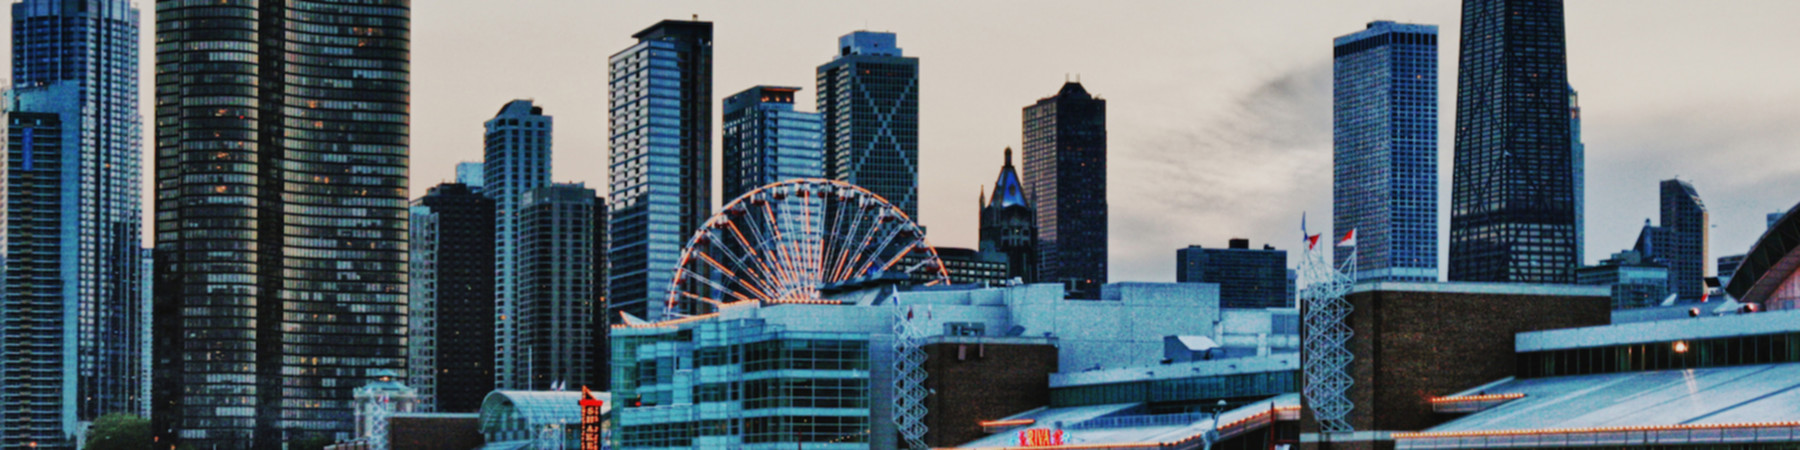

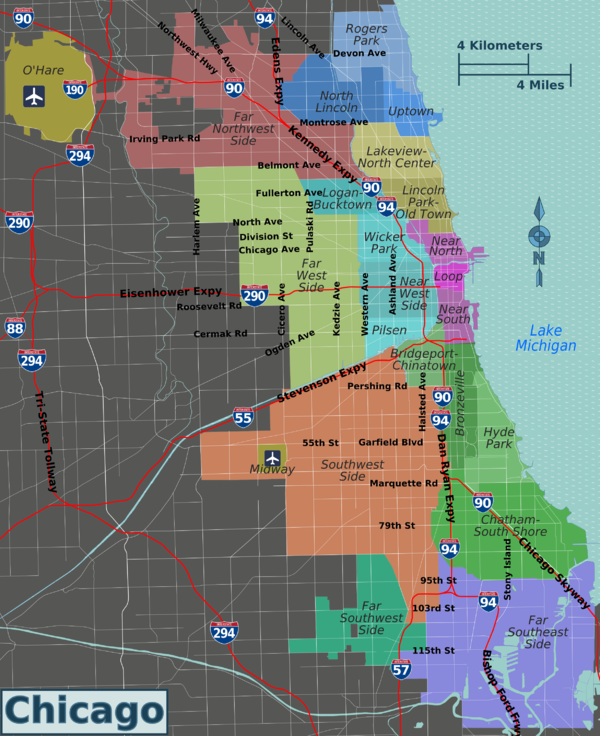

In [8]:
location = "Chicago"
image_paths = fetch_and_display_images(location, num_images=2)
display_downloaded_images(image_paths)

# 1.3 Do Section

In [9]:
"""Extracts the 'Do' section with proper handling of subheadings and content, preserving original formatting."""

def get_do_section(soup):
    if soup is None:
        return ["Invalid soup object."]

    # Find the "Do" section
    do_section = soup.find("span", id="Do")
    if not do_section:
        # Try alternative ways to find the Do section
        do_headers = soup.find_all(["h2", "h3"], string=lambda text: text and "Do" in text)
        if do_headers:
            do_section = do_headers[0].find("span", id=lambda x: x and "Do" in x)

    if not do_section:
        return ["No 'Do' section found on this page."]

    # Get the parent element of the section
    do_parent = do_section.find_parent()

    # Initialize result structure
    result = [{"type": "main_header", "text": "Things to Do"}]

    current_subheading = None
    line_count = 0

    # Track the next major section to know when to stop
    for sibling in do_parent.find_next_siblings():
        # Stop at the next major section (h2)
        if sibling.name == "h2":
            break

        # Capture subheadings (h3, h4)
        if sibling.name in ["h3", "h4"]:
            # Reset line count for new subheading
            line_count = 0

            # Extract subheading text and remove [edit]
            subheading_text = sibling.get_text(strip=True)
            subheading_text = subheading_text.replace("[edit]", "").strip()
            current_subheading = subheading_text

            # Add subheading to result
            result.append({"type": "spacer"})  # Empty line for spacing
            result.append({"type": "subheader", "text": current_subheading})

        # Process content under the current subheading
        elif current_subheading and line_count < 10:
            # For paragraphs (get original text with spacing preserved)
            if sibling.name == "p":
                # Get text with original spacing
                para_text = sibling.get_text().strip()

                # Add as a paragraph
                if para_text:
                    result.append({"type": "paragraph", "text": para_text})
                    line_count += 1

            # For lists (ul/ol)
            elif sibling.name in ["ul", "ol"]:
                list_items = sibling.find_all("li")

                for item in list_items:
                    if line_count >= 10:
                        break

                    # Preserve original formatting of list item
                    item_text = item.get_text().strip()
                    if item_text:
                        result.append({"type": "bullet", "text": item_text})
                        line_count += 1

            # For other content containers
            elif sibling.name == "div":
                # Process paragraphs within divs
                paragraphs = sibling.find_all("p")
                for p in paragraphs:
                    if line_count >= 10:
                        break

                    p_text = p.get_text().strip()
                    if p_text:
                        result.append({"type": "paragraph", "text": p_text})
                        line_count += 1

                # Process lists within divs
                lists = sibling.find_all(["ul", "ol"])
                for list_elem in lists:
                    list_items = list_elem.find_all("li")
                    for item in list_items:
                        if line_count >= 10:
                            break

                        item_text = item.get_text().strip()
                        if item_text:
                            result.append({"type": "bullet", "text": item_text})
                            line_count += 1

    # If we found nothing beyond the main title
    if len(result) <= 1:
        return [{"type": "error", "text": "No detailed sections found under 'Do'."}]

    return result


In [10]:
def print_activities(activities, max_width=50):
    for item in activities:
        if item["type"] == "main_header":
            display(HTML(f"<h2 style='color: Navy; font-weight: bold;'>{item['text']}</h2>"))

        elif item["type"] == "subheader":
            display(HTML(f"<h3 style='color: green; font-weight: bold;'>{item['text']}</h3>"))

        elif item["type"] == "paragraph":
            # Wrap text to avoid horizontal scrolling
            wrapped_text = textwrap.fill(item["text"], width=max_width)
            display(HTML(f"<p>{wrapped_text}</p>"))

        elif item["type"] == "bullet":
            # Wrap text to avoid horizontal scrolling, keeping list items intact
            wrapped_text = textwrap.fill(item["text"], width=max_width-2)
            display(HTML(f"<ul><li>{wrapped_text}</li></ul>"))

        elif item["type"] == "spacer":
            display(HTML("<br>"))  # Empty line

        elif item["type"] == "error":
            display(HTML(f"<p style='color: red;'>{item['text']}</p>"))


def get_activities(location, max_width=50):
    soup, error = fetch_wikitravel_page(location)
    if error:
        display(HTML(f"<p style='color: red;'>{error}</p>"))
        return

    activities = get_do_section(soup)
    print_activities(activities, max_width)


In [11]:
location = "Yosemite_National_Park"
get_activities(location)


# 2. Weather Forecast using API

In [12]:
import requests
import numpy as np

In [13]:
API_KEY = "679eb99136e1f718327479ieo809833"

"""Convert school address to coordinates using Geocode.maps.co API"""

def get_coordinates(school_address):

    try:
        url = "https://geocode.maps.co/search"
        params = {
            'q': school_address,
            'api_key': API_KEY
        }
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        if data:
            return {
                'latitude': data[0]['lat'],
                'longitude': data[0]['lon']
            }
        return None
    except Exception as e:
        print(f"Error getting coordinates: {e}")
        return None

"""Fetch weather data from Open-Meteo API for specified number of days"""

def get_weather_data(lat, lon, days):

    try:
        # Construct the URL to fetch weather data for the given number of days
        url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&daily=temperature_2m_max,temperature_2m_min,windspeed_10m_max,precipitation_sum&timezone=auto"
        response = requests.get(url)
        response.raise_for_status()
        weather_data = response.json()

        if 'daily' in weather_data:
            # Extract weather data for the specified days
            daily_data = weather_data['daily']
            daily_weather = {
                'temperature_max': daily_data['temperature_2m_max'],
                'temperature_min': daily_data['temperature_2m_min'],
                'windspeed_max': daily_data['windspeed_10m_max'],
                'precipitation_sum': daily_data['precipitation_sum'],
                'time': daily_data['time']
            }

            # Create a dictionary to hold the average data for each day
            averages = {}
            for i, date in enumerate(daily_weather['time']):
                if date in days:
                    temp_avg = np.mean([daily_weather['temperature_max'][i], daily_weather['temperature_min'][i]])
                    wind_avg = daily_weather['windspeed_max'][i]
                    precip_avg = daily_weather['precipitation_sum'][i]

                    averages[date] = {
                        'average_temperature': temp_avg,
                        'average_windspeed': wind_avg,
                        'average_precipitation': precip_avg
                    }

            return averages
        else:
            print("Error: No daily weather data found.")
            return None
    except Exception as e:
        print(f"Error getting weather data: {e}")
        return None

"""Calculate average weather data (temperature, wind speed, and precipitation) for the given days"""

def calculate_averages(location, days):

    # Get the coordinates of the location
    coords = get_coordinates(location)

    if coords:

        weather = get_weather_data(coords['latitude'], coords['longitude'], days)

        if weather:
            return weather
        else:
            print("Unable to get weather data.")
            return None
    else:
        print("Unable to get coordinates.")
        return None


In [14]:
from tabulate import tabulate


def print_weather_forecast(averages, location):
    table_data = []
    for day, avg in averages.items():
        table_data.append([
            day,
            f"{avg['average_temperature']:.2f}°C 🌡️",
            f"{avg['average_windspeed']:.2f} km/h 💨",
            f"{avg['average_precipitation']:.2f} mm 🌧️" if avg['average_precipitation'] > 0 else "No Rain ☀️"
        ])

    # Print formatted table
    print(f"\n🌍 Weather forecast for {location}: 🌍\n")
    print(tabulate(table_data, headers=["Date 📅", "Avg Temp 🌡️", "Wind Speed 💨", "Precipitation 🌧️"]))


In [15]:
location = "San Francisco"
days = ["2025-03-08", "2025-03-09", "2025-03-10"]
averages = calculate_averages(location, days)
print_weather_forecast(averages, "San Francisco")


🌍 Weather forecast for San Francisco: 🌍

Date 📅     Avg Temp 🌡️    Wind Speed 💨    Precipitation 🌧️
----------  -------------  ---------------  ------------------
2025-03-08  9.70°C 🌡️      18.00 km/h 💨    No Rain ☀️
2025-03-09  11.65°C 🌡️     26.40 km/h 💨    No Rain ☀️
2025-03-10  13.80°C 🌡️     13.70 km/h 💨    No Rain ☀️


# 3. Restaurant Suggestions

In [16]:
import requests
import pandas as pd

""" Fetch restaurant details from OpenStreetMap using Overpass API. """

def get_osm_restaurants(city_name):

    overpass_url = "http://overpass-api.de/api/interpreter"

    # Overpass Query to fetch restaurant data in the given city
    overpass_query = f"""
    [out:json];
    area["name"="{city_name}"]->.searchArea;
    node["amenity"="restaurant"](area.searchArea);
    out body;
    """

    # Send request to Overpass API
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()

    # Extract restaurant details
    restaurants = []
    for element in data.get("elements", []):
        tags = element.get("tags", {})

        restaurant_info = {
            "Name": tags.get("name", "N/A"),
            "Cuisine": tags.get("cuisine", "N/A"),
            "Latitude": element.get("lat", "N/A"),
            "Longitude": element.get("lon", "N/A"),
            "Street": tags.get("addr:street", "N/A"),
            "City": tags.get("addr:city", city_name),
            "Postcode": tags.get("addr:postcode", "N/A"),
            "Country": tags.get("addr:country", "N/A"),
            "Phone": tags.get("contact:phone", tags.get("phone", "N/A")),
            "Website": tags.get("contact:website", tags.get("website", "N/A")),
            "Email": tags.get("contact:email", tags.get("email", "N/A")),
            "Opening Hours": tags.get("opening_hours", "N/A"),
            "Takeaway": tags.get("takeaway", "N/A"),
            "Delivery": tags.get("delivery", "N/A"),
            "Outdoor Seating": tags.get("outdoor_seating", "N/A"),
            "Wheelchair Accessible": tags.get("wheelchair", "N/A"),
            "Smoking Allowed": tags.get("smoking", "N/A"),
            "WiFi Available": tags.get("internet_access", "N/A"),
            "Drive-Through": tags.get("drive_through", "N/A"),
        }

        restaurants.append(restaurant_info)

    # Convert list to Pandas DataFrame
    df = pd.DataFrame(restaurants)

    return df


In [17]:
df = get_osm_restaurants("San Francisco")
df.head()


,Name,Cuisine,Latitude,Longitude,Street,City,Postcode,Country,Phone,Website,Email,Opening Hours,Takeaway,Delivery,Outdoor Seating,Wheelchair Accessible,Smoking Allowed,WiFi Available,Drive-Through
0,Mel's Drive-in,diner,37.799551,-122.437048,N/A,San Francisco,94123,N/A,4159212867,https://melsdrive-in.com/restaurant/mels-lomba...,N/A,Su-Th 06:30-00:00; Fr-Sa 06:30-03:00,N/A,N/A,N/A,yes,N/A,N/A,N/A
1,Mezze and Mooore,lebanese,37.768092,-122.424586,Guerrero Street,San Francisco,94103,US,+1 415 6545089,https://www.mezzeandmooore.com/,mezzeandmooore@gmail.com,Mo-Sa 12:00-21:00; Su off,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,John's Grill Live Jazz,steak;seafood,37.785464,-122.407152,Ellis Street,San Francisco,94102,N/A,+1 415-986-0069,https://www.johnsgrill.com/,N/A,N/A,N/A,N/A,yes,N/A,N/A,N/A,N/A
3,Frankie’s Java House,N/A,37.781426,-122.387807,N/A,San Francisco,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,yes,N/A,N/A,N/A,N/A
4,Caffe Centro,N/A,37.781708,-122.394253,N/A,San Francisco,N/A,N/A,N/A,N/A,N/A,Mo-Su 08:00-15:00,N/A,N/A,N/A,N/A,N/A,N/A,N/A


In [18]:
df.shape

(1903, 19)

In [20]:
from tabulate import tabulate

def print_top_restaurants(df):
    # Get the top 10 rows of filtered columns
    df_filtered = df[['Name', 'Cuisine', 'City']].head(10)

    # Prepare the table headers with emojis
    headers = ['🍽️ Restaurant Name', '🍕 Cuisine', '🌆 City']

    # Convert the DataFrame to a list of lists (for tabulate)
    table_data = df_filtered.values.tolist()

    # Print the table with emojis
    print(tabulate(table_data, headers=headers, tablefmt="pretty"))

df = get_osm_restaurants("Yosemite National Park")
print_top_restaurants(df)

+--------------------------+------------+------------------------+
|    🍽️ Restaurant Name    | 🍕 Cuisine |        🌆 City         |
+--------------------------+------------+------------------------+
|   Seven Tents Pavilion   |    N/A     | Yosemite National Park |
|      Degnan's Loft       |    N/A     | Yosemite National Park |
| Wawona Hotel Dining Room |    N/A     | Yosemite National Park |
|     White Wolf Lodge     |    N/A     | Yosemite National Park |
|       Meadow Grill       |    N/A     | Yosemite National Park |
| Curry Village Pizza Deck |   pizza    |    Yosemite Valley     |
|   Ahwahnee Dining Room   |  american  | Yosemite National Park |
+--------------------------+------------+------------------------+


# 4. Putting Everything Together

In [25]:
# input values
# Please change these values as per your requirement
# Note: The dates can only be future dates, starting today
location = "Yosemite_National_Park"
days = ["2025-03-09", "2025-03-10", "2025-03-11"]

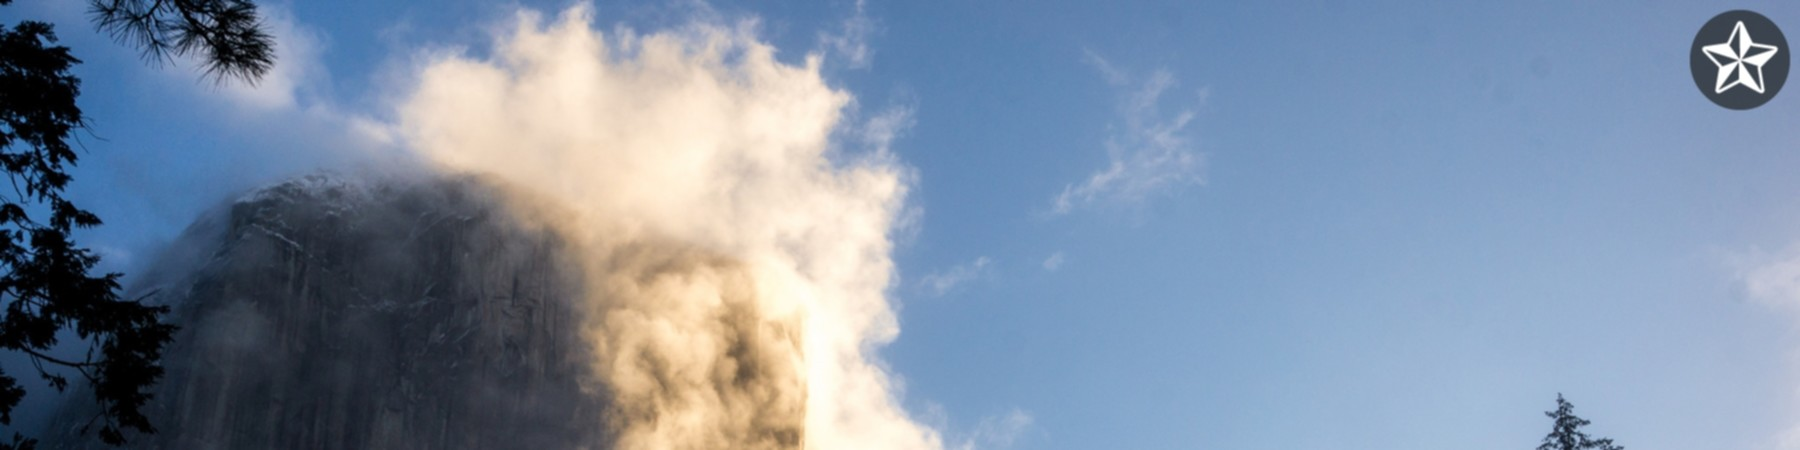

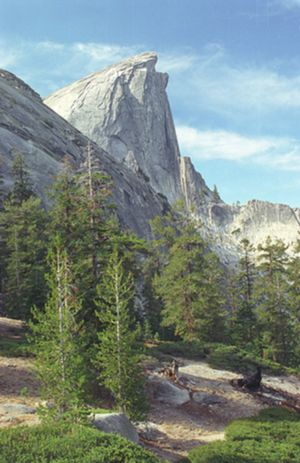


🌍 Weather forecast for Yosemite_National_Park: 🌍

Date 📅     Avg Temp 🌡️    Wind Speed 💨    Precipitation 🌧️
----------  -------------  ---------------  ------------------
2025-03-09  -4.75°C 🌡️     25.70 km/h 💨    No Rain ☀️
2025-03-10  -4.65°C 🌡️     12.90 km/h 💨    No Rain ☀️
2025-03-11  -4.35°C 🌡️     21.20 km/h 💨    1.60 mm 🌧️




+--------------------------+------------+------------------------+
|    🍽️ Restaurant Name    | 🍕 Cuisine |        🌆 City         |
+--------------------------+------------+------------------------+
|   Seven Tents Pavilion   |    N/A     | Yosemite National Park |
|      Degnan's Loft       |    N/A     | Yosemite National Park |
| Wawona Hotel Dining Room |    N/A     | Yosemite National Park |
|     White Wolf Lodge     |    N/A     | Yosemite National Park |
|       Meadow Grill       |    N/A     | Yosemite National Park |
| Curry Village Pizza Deck |   pizza    |    Yosemite Valley     |
|   Ahwahnee Dining Room   |  american  | Yosemite National Park |
+--------------------------+------------+------------------------+


In [26]:
text1 = "🌍✨ Welcome to Journey Genie! ✨🌍"
text2 = "Your personalized recommendations for location: " + location

# Display the first text as an h1 and the second text as an italicized h4
display(HTML(f"<h1 style='color: Purple; font-weight: bold;'>{text1}</h1>"))
display(HTML(f"<h4 style='color: orange; font-style: italic;'>{text2}</h4>"))

# Attractions - See
get_attractions(location, terminal_width)

# Images
print("\n")
text = "Images"
display(HTML(f"<h2 style='color: Navy; font-weight: bold;'>{text}</h2>"))
image_paths = fetch_and_display_images(location, num_images=2)
display_downloaded_images(image_paths)

# Activities - Do
print("\n")
get_activities(location)

# Weather
averages = calculate_averages(location, days)
print("\n")
text = "Weather"
display(HTML(f"<h2 style='color: Navy; font-weight: bold;'>{text}</h2>"))
print_weather_forecast(averages, location)

# Restaurants
l = " ".join(location.split("_"))
df = get_osm_restaurants(l)
print("\n")
text = "Restaurants"
display(HTML(f"<h2 style='color: Navy; font-weight: bold;'>{text}</h2>"))
print_top_restaurants(df)

# Documentation

Travel Genie

**Business Use Case**

What makes Travel Complete (Mind Map)
What does Travel Genie Offers (Places, Thing to do, Weather, Restaurant Suggestions)

**Project Overview**

Given a location,
- the app scrapes Travel related data to suggest must-visit places,
- fetches real-time weather forecasts for the duration of the visit,
- Additionally recommends top food spots nearby.

Integrating web scraping and API-based data retrieval


**Implementation**

(Wiki Travel - Scrape, Open Mateo - API, Open Street Map - API and DF)
- Wiki - Web Scarping (Wiki Travel - Things, Places, Images) for a location
- OM - API - Weather Forecast (Avg of Rain, temp, Wind) for period of time
- OSM - API - Restaurant Details for a location

**Limitations**

Long Texts
Web Scraping Disabling
API Limited Acesses

**Demo**

SS of outputs

